In [33]:
import argparse
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import json
import time
import torch.nn.functional as F
import sys
import cnn_drone_net_utils
import torchvision
import torchvision.transforms as transforms
import cv2
import io
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms, models
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from PIL import Image
from matplotlib.pyplot import figure

In [34]:
# To start tensorboard in CMD run: 'tensorboard --logdir=runs'
# More cool stuff with tensor board here: https://www.youtube.com/watch?v=VJW9wU-1n18 

In [35]:
TENSORBOARD_PATH = "runs"
DATA_PATH = "./data"
OUT_PATH = "./output"
DATA_UAV = "UAV_Dataset"
DATA_GE = "GoogleEarth_Dataset"
GE_DATA_PATH = f'{DATA_PATH}/{DATA_GE}'
UAV_DATA_PATH = f'{DATA_PATH}/{DATA_UAV}'
DATA_UAV_COMPRESSED_FILENAME = "UAV_Dataset.zip"
DATA_BLOB_UAV_COMPRESSED = "https://nlpdatastorage.blob.core.windows.net/cnndata/UAV_Dataset.zip"
DATA_GE_COMPRESSED_FILENAME = "GoogleEarth_Dataset.zip"
DATA_BLOB_GE_COMPRESSED = "https://nlpdatastorage.blob.core.windows.net/cnndata/GoogleEarth_Dataset.zip"

In [36]:
os.makedirs(OUT_PATH, exist_ok=True)
os.makedirs(DATA_PATH, exist_ok=True)

In [37]:
# Cleanup
import os, shutil
do_cleanup = True
def remove_folder(folder):
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))
if(do_cleanup):
    remove_folder(f"./{TENSORBOARD_PATH}")
    remove_folder(DATA_PATH)
    remove_folder(OUT_PATH)

In [38]:
############## TENSORBOARD ########################
writer = SummaryWriter(TENSORBOARD_PATH)
###################################################

In [39]:
download_uav_data =  DATA_UAV_COMPRESSED_FILENAME not in os.listdir(DATA_PATH) 
download_ge_data =  DATA_GE_COMPRESSED_FILENAME not in os.listdir(DATA_PATH) 

uav_zipped = f'{UAV_DATA_PATH}/{DATA_UAV_COMPRESSED_FILENAME}'
ge_zipped = f'{GE_DATA_PATH}/{DATA_GE_COMPRESSED_FILENAME}'

if(download_uav_data):
    print(f"Downloading data from {DATA_BLOB_UAV_COMPRESSED} and saving in {uav_zipped}")
    cnn_drone_net_utils.download_data(DATA_BLOB_UAV_COMPRESSED, out_path=uav_zipped)

if(download_ge_data):
    print(f"Downloading data from {DATA_BLOB_GE_COMPRESSED} and saving in {ge_zipped}")
    cnn_drone_net_utils.download_data(DATA_BLOB_GE_COMPRESSED, out_path=ge_zipped)

print(f"Unzipping {uav_zipped} to directory {DATA_PATH}")
cnn_drone_net_utils.unzip_file(uav_zipped, DATA_PATH)

print(f"Unzipping {ge_zipped} to directory {DATA_PATH}")
cnn_drone_net_utils.unzip_file(ge_zipped, DATA_PATH)

print(f"{DATA_PATH} contents: {', '.join(os.listdir(DATA_PATH))}")

Unzipping ./data/UAV_Dataset/UAV_Dataset.zip to directory ./data
Unzipping ./data/GoogleEarth_Dataset/GoogleEarth_Dataset.zip to directory ./data
./data contents: GoogleEarth_Dataset, UAV_Dataset


In [40]:
##### Hyper Parameters #####
lr = 0.0003
batch_size = 8
dropout = 0.2

In [41]:
train_data_dir = GE_DATA_PATH
train_loader = cnn_drone_net_utils.load_dataset(train_data_dir, batch_size = batch_size)
print(f'Initialized train set loader from directory {GE_DATA_PATH}, classes: {train_loader.dataset.classes}')

val_data_dir = UAV_DATA_PATH
val_loader = cnn_drone_net_utils.load_dataset(val_data_dir, batch_size = batch_size)
print(f'Initialized validation set loader from directory {UAV_DATA_PATH}, classes: {val_loader.dataset.classes}')

Initialized train set loader from directory ./data/GoogleEarth_Dataset, classes: ['FlightZone', 'NonFlightZone']
Initialized validation set loader from directory ./data/UAV_Dataset, classes: ['FlightZone', 'NonFlightZone']


Sampling training set:


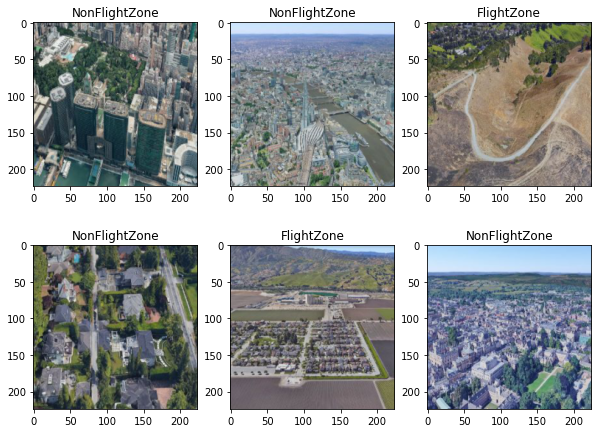

In [42]:
# Sampling train data set
print("Sampling training set:")
examples = iter(train_loader)
example_data, example_targets = examples.next()

fig = figure(num=None, figsize=(10, 7.5))

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(torchvision.utils.make_grid(example_data[i], nrow=1).permute(1, 2, 0))
    plt.title(train_loader.dataset.classes[example_targets[i]])

plt.show()

######################## TENSORBOARD ########################
cnn_drone_net_utils.plot_to_tensorboard("training_set_sample",writer, fig, 0)
#############################################################

plt.close()

Sampling validation set:


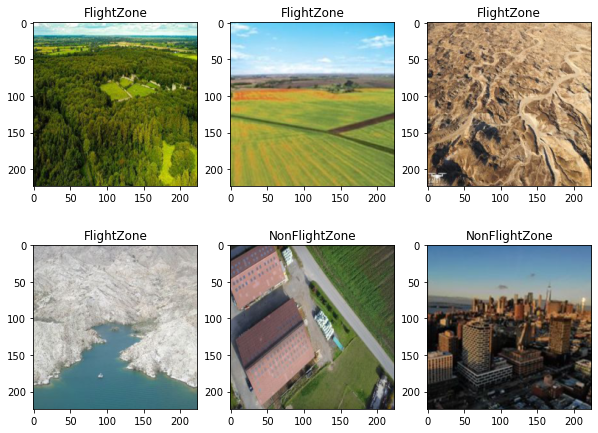

In [43]:
# Sampling validation data set
print("Sampling validation set:")
examples = iter(val_loader)
example_data, example_targets = examples.next()

fig = figure(num=None, figsize=(10, 7.5))

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(torchvision.utils.make_grid(example_data[i], nrow=1).permute(1, 2, 0))
    plt.title(train_loader.dataset.classes[example_targets[i]])

plt.show()

######################## TENSORBOARD ########################
cnn_drone_net_utils.plot_to_tensorboard("validation_set_sample",writer, fig, 0)
#############################################################

plt.close()

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)
print(f'Loaded pretrained model: {models.resnet50.__name__}')

Loaded pretrained model: resnet50


In [45]:
print("Freezing the pretrained model's parameters")
for param in model.parameters():
    param.requires_grad = False
    
print("Initialzing the last fully connected layer of the pretrained model")
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(dropout),
                                 nn.Linear(512, 10),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=lr)
model.to(device)

Freezing the pretrained model's parameters
Initialzing the last fully connected layer of the pretrained model


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [46]:
############## TENSORBOARD ########################
writer.add_graph(model, example_data.to(device))
###################################################

In [ ]:
epochs = 1
steps = 0
running_loss = 0
print_every = 1
train_losses, val_losses = [], []
for epoch in range(epochs):
    for inputs, labels in train_loader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if steps % print_every == 0:
            val_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    val_loss += batch_loss.item()
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    
                    ############## TENSORBOARD ########################
                    right_predict_indices_sample = (equals).nonzero()[:1]
                    wrong_predict_indices_sample = (equals == False).nonzero()[:1]
                    
                    fig = figure(num=None, figsize=(12, 12))
                    # print("Good Predictions")
                    img_idx = right_predict_indices_sample[0][0]
                    plt.imshow(torchvision.utils.make_grid(inputs[img_idx].cpu(), nrow=1).permute(1, 2, 0))
                    plt.title(f'Expected: {val_loader.dataset.classes[labels[img_idx]]}')
                    # plt.show()
                    cnn_drone_net_utils.plot_to_tensorboard("correct_predictions",writer, fig, steps)
                    plt.close()

                    fig = figure(num=None, figsize=(12, 12))
                    # print("Bad Predictions")
                    img_idx = wrong_predict_indices_sample[0][0]
                    plt.imshow(torchvision.utils.make_grid(inputs[img_idx].cpu(), nrow=1).permute(1, 2, 0))
                    plt.title(f'Expected: {val_loader.dataset.classes[labels[img_idx]]}')

                    # plt.show()
                    cnn_drone_net_utils.plot_to_tensorboard("correct_predictions",writer, fig, steps)
                    plt.close()
                    ###################################################

                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            train_losses.append(running_loss / len(train_loader))
            val_losses.append(val_loss / len(val_loader))
            print(f"Epoch {epoch + 1}/{epochs}.. "
                  f"Train loss: {running_loss / print_every:.3f}.. "
                  f"Validation loss: {val_loss / len(val_loader):.3f}.. "
                  f"Validation accuracy: {accuracy / len(val_loader):.3f} "
                  f"Step: {steps}/{len(train_loader)}")
            ############## TENSORBOARD ########################
            writer.add_scalar('training loss', running_loss / print_every, steps)
            writer.add_scalar('validation accuracy', accuracy / len(val_loader), steps)
            writer.add_scalar('validation loss', val_loss / len(val_loader), steps)
            running_correct = 0
            running_loss = 0.0
            ###################################################
            running_loss = 0
            model.train()
            
print("Done training model")

In [ ]:
torch.save(model, f'{OUT_PATH}/model.pth')

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [ ]:
############## TENSORBOARD ########################
writer.close()
###################################################